In [110]:
import pandas as pd# type: ignore
import numpy as np# type: ignore
import matplotlib.pyplot as plt # type: ignore
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


In [44]:
dataset =pd.read_csv("loan_data.csv")
dataset

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [45]:
dataset.shape

(614, 13)

In [46]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [47]:
dataset.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [48]:
pd.crosstab(dataset['Credit_History'],dataset['Loan_Status'],margins=True)

Loan_Status,N,Y,All
Credit_History,,,
0.0,82,7,89
1.0,97,378,475
All,179,385,564


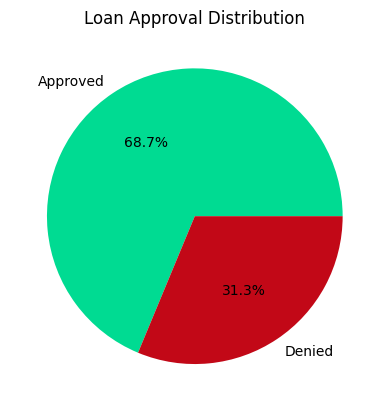

In [105]:
# Visualize the balance of loan approvals to see if we will need to fix any imbalance
plt.pie(dataset['Loan_Status'].value_counts().values, labels=['Approved', 'Denied'], colors=['#00db92', '#C20817'], autopct='%1.1f%%')
plt.title('Loan Approval Distribution')
plt.show()

In [102]:
# Define a list of categorical columns
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

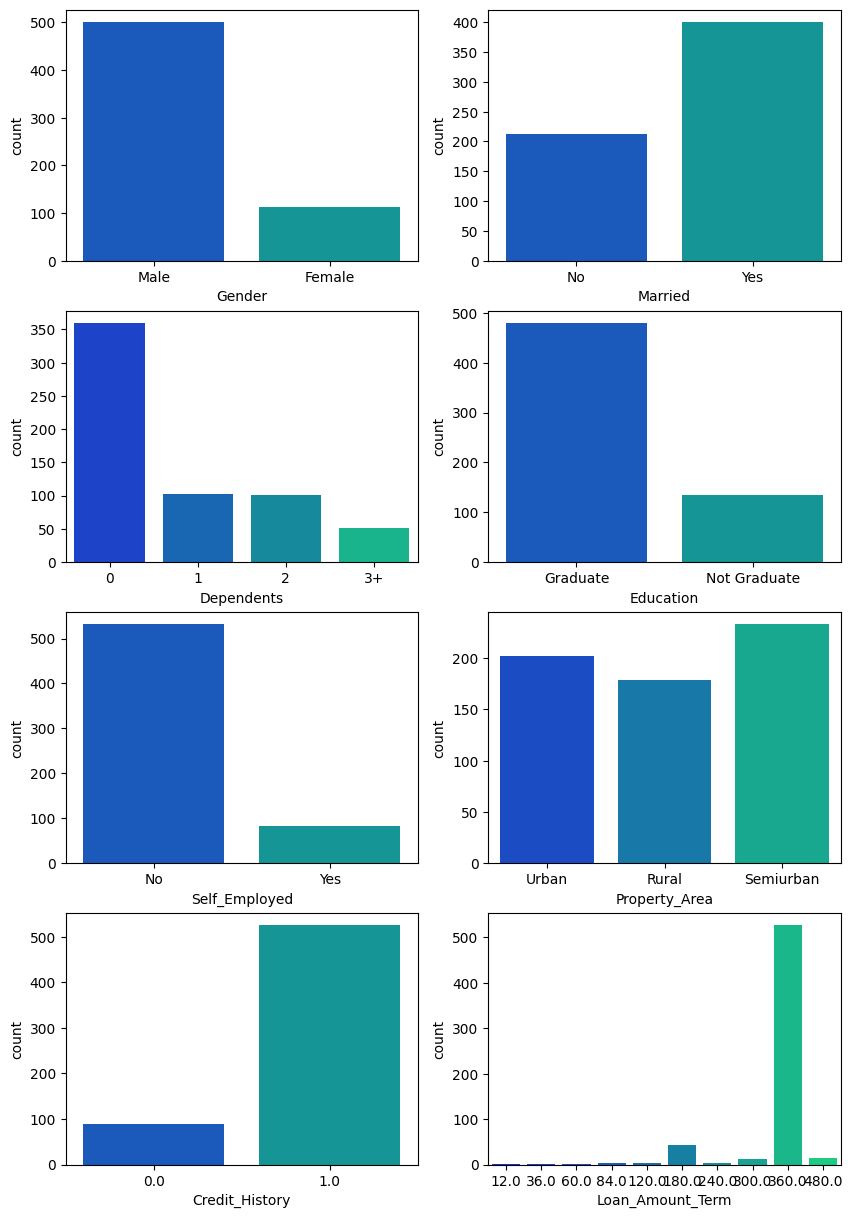

In [111]:
# Visualize the distribution of independent features
plt.figure(figsize=(10,15))

index = 1
for col in categorical_cols[:6]+['Credit_History', 'Loan_Amount_Term']:
    plt.subplot(4,2,index)
    sns.countplot(data=dataset, x=col, palette='winter')
    index = index + 1
plt.show()

<Axes: >

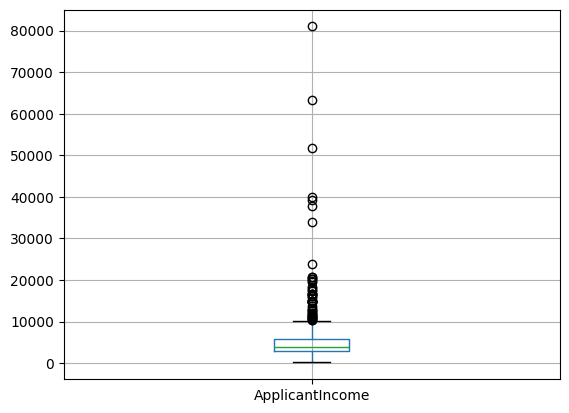

In [49]:
dataset.boxplot(column='ApplicantIncome')

<Axes: >

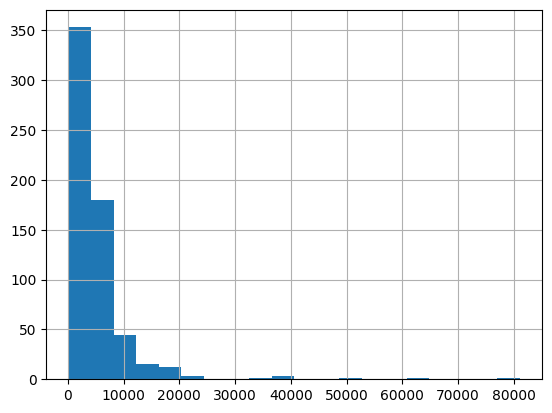

In [50]:
dataset['ApplicantIncome'].hist(bins=20)

<Axes: >

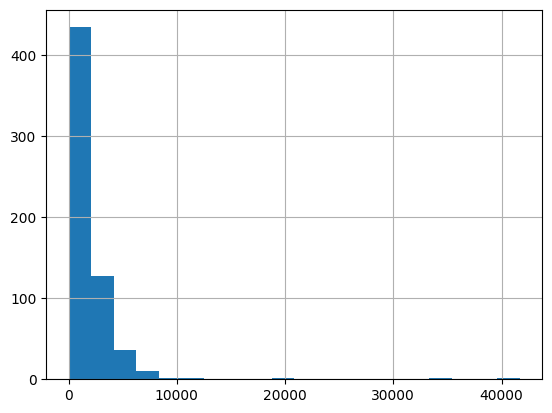

In [51]:
dataset['CoapplicantIncome'].hist(bins=20)

<Axes: title={'center': 'ApplicantIncome'}, xlabel='Education'>

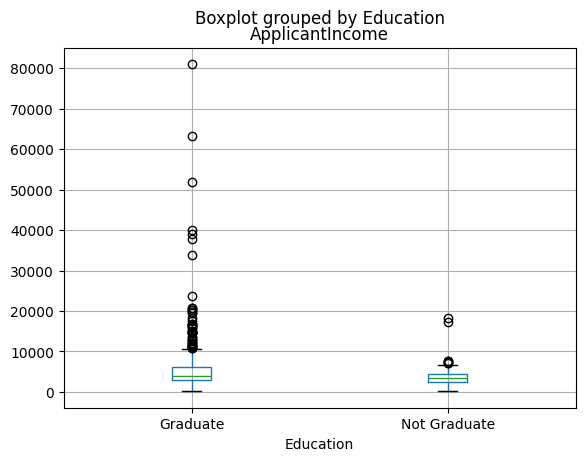

In [52]:
dataset.boxplot(column='ApplicantIncome',by='Education')

<Axes: title={'center': 'ApplicantIncome'}, xlabel='LoanAmount'>

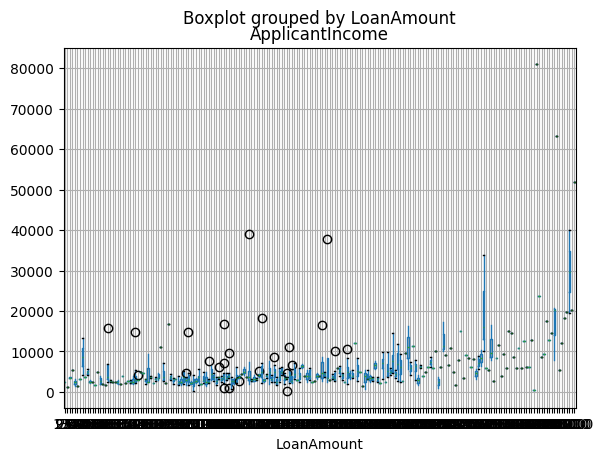

In [53]:
dataset.boxplot(column='ApplicantIncome',by='LoanAmount')

<Axes: >

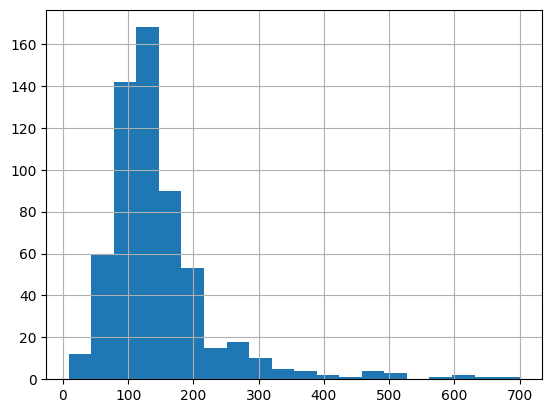

In [54]:
dataset['LoanAmount'].hist(bins=20)

<Axes: >

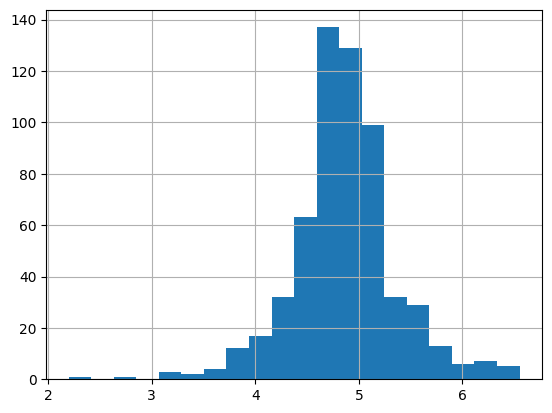

In [55]:
##after applying log it settled little bit in the middle (Normalising the data)
dataset['LoanAmount_Log']=np.log(dataset['LoanAmount'])
dataset['LoanAmount_Log'].hist(bins=20)

In [56]:
## finding nulls in the data
dataset.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
LoanAmount_Log       22
dtype: int64

Removing Blanks or null in data and icrease its sanity

In [112]:
dataset['Gender'].fillna(dataset['Gender'].mode()[0],inplace=True)
dataset['Married'].fillna(dataset['Married'].mode()[0],inplace=True)
dataset['Dependents'].fillna(dataset['Dependents'].mode()[0],inplace=True)
dataset['Self_Employed'].fillna(dataset['Self_Employed'].mode()[0],inplace=True)
dataset.LoanAmount=dataset.LoanAmount.fillna(dataset.LoanAmount.mean())
dataset.LoanAmount_Log=dataset.LoanAmount_Log.fillna(dataset.LoanAmount_Log.mean())
dataset['Loan_Amount_Term'].fillna(dataset['Loan_Amount_Term'].mode()[0],inplace=True)
dataset['Credit_History'].fillna(dataset['Credit_History'].mode()[0],inplace=True)

In [58]:
dataset.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
LoanAmount_Log       0
dtype: int64

In [59]:
dataset['TotalIncome'] = dataset['ApplicantIncome'] + dataset['CoapplicantIncome']


dataset['Total_Income_Log'] = np.log(dataset['TotalIncome'])

<Axes: >

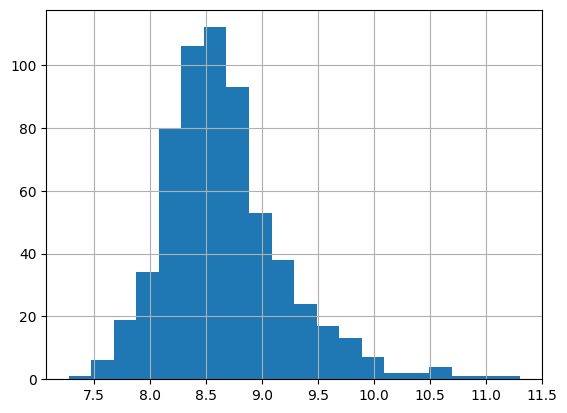

In [60]:
dataset['Total_Income_Log'].hist(bins=20)

In [61]:
dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_Log,TotalIncome,Total_Income_Log
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,4.857444,5849.0,8.674026
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,4.852030,6091.0,8.714568
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,4.189655,3000.0,8.006368
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,4.787492,4941.0,8.505323
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,4.948760,6000.0,8.699515


Making Independat and Dependant Variable

In [62]:
## Independant Variable
X= dataset.iloc[:,np.r_[1:5,9:11,13:15]].values
## Dependnat Variables
Y = dataset.iloc[:,12].values

In [63]:
X

array([['Male', 'No', '0', ..., 1.0, 4.857444178729352, 5849.0],
       ['Male', 'Yes', '1', ..., 1.0, 4.852030263919617, 6091.0],
       ['Male', 'Yes', '0', ..., 1.0, 4.189654742026425, 3000.0],
       ...,
       ['Male', 'Yes', '1', ..., 1.0, 5.53338948872752, 8312.0],
       ['Male', 'Yes', '2', ..., 1.0, 5.231108616854587, 7583.0],
       ['Female', 'No', '0', ..., 0.0, 4.890349128221754, 4583.0]],
      dtype=object)

In [64]:
Y

array(['Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y',
       'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'N', 'N', 'N', 'Y',
       'Y', 'Y', 'N', 'Y', 'N', 'N', 'N', 'Y', 'N', 'Y', 'N', 'Y', 'Y',
       'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y',
       'N', 'N', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'N',
       'N', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'N', 'Y', 'N', 'N', 'N',
       'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y',
       'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N',
       'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'N', 'N', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N', 'Y', 'N', 'N', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'Y', 'N',
       'Y', 'Y', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'N', 'N

Train  and Test Dataset (SKLEARN)

In [65]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test =train_test_split(X,Y,test_size=0.2,random_state=0)


In [66]:
X_train

array([['Male', 'Yes', '0', ..., 1.0, 4.875197323201151, 5858.0],
       ['Male', 'No', '1', ..., 1.0, 5.278114659230517, 11250.0],
       ['Male', 'Yes', '0', ..., 0.0, 5.003946305945459, 5681.0],
       ...,
       ['Male', 'Yes', '3+', ..., 1.0, 5.298317366548036, 8334.0],
       ['Male', 'Yes', '0', ..., 1.0, 5.075173815233827, 6033.0],
       ['Female', 'Yes', '0', ..., 1.0, 5.204006687076795, 6486.0]],
      dtype=object)

Encoding in numeric

In [67]:
from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()

In [68]:
for i in range(0,5):
    X_train[:,i] =labelencoder_X.fit_transform(X_train[:,i])

In [69]:
X_train[:,7]=labelencoder_X.fit_transform(X_train[:,7])
X_train

array([[1, 1, 0, ..., 1.0, 4.875197323201151, 267],
       [1, 0, 1, ..., 1.0, 5.278114659230517, 407],
       [1, 1, 0, ..., 0.0, 5.003946305945459, 249],
       ...,
       [1, 1, 3, ..., 1.0, 5.298317366548036, 363],
       [1, 1, 0, ..., 1.0, 5.075173815233827, 273],
       [0, 1, 0, ..., 1.0, 5.204006687076795, 301]], dtype=object)

In [76]:
labelencoder_Y = LabelEncoder()
Y_train = labelencoder_Y.fit_transform(Y_train)
Y_train

array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,

In [78]:
for i in range (0,5):
    X_test[:,i]=labelencoder_X.fit_transform(X_test[:,i])
        

In [80]:
X_test[:,7]=labelencoder_X.fit_transform(X_test[:,7])

In [81]:
labelencoder_Y=LabelEncoder()
Y_test=labelencoder_Y.fit_transform(Y_test)


In [82]:
Y_test

array([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1])

Scaling the data

In [83]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)


ML Algorithms on Data------------------------------------------------------------------------

Decision Tree Algorithm

In [89]:
from sklearn.tree import DecisionTreeClassifier
DTClassifier = DecisionTreeClassifier(criterion = 'entropy' ,random_state=0)
DTClassifier.fit(X_train,Y_train)


DecisionTreeClassifier(criterion='entropy', random_state=0)

Prediction 

In [93]:
Y_pred=DTClassifier.predict(X_test)
Y_pred

array([0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1])

Accuracy Checkon on Decision Tree Algo

In [94]:
from sklearn import metrics
print( 'The accuracy of decision tree is:',metrics.accuracy_score(Y_pred,Y_test))

The accuracy of decision tree is: 0.7073170731707317


In [96]:
from sklearn.naive_bayes import GaussianNB
NBClassifier= GaussianNB()
NBClassifier.fit(X_train,Y_train)

GaussianNB()

Predict


In [97]:
Y_pred = NBClassifier.predict(X_test)
Y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1])

In [98]:
print( 'The accuracy of decision tree is:',metrics.accuracy_score(Y_pred,Y_test))

The accuracy of decision tree is: 0.8292682926829268


Giving test data to find out Loan prediction

In [116]:
testdata=pd.read_csv("Test_data.csv")
testdata

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban
1,LP001003,Male,Yes,1,Graduate,No,23444,1508.0,128.0,360.0,1.0,Rural
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban
...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban


In [117]:
testdata.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
dtype: int64

In [118]:
testdata['Gender'].fillna(testdata['Gender'].mode()[0],inplace=True)
testdata['Married'].fillna(testdata['Married'].mode()[0],inplace=True)
testdata['Dependents'].fillna(testdata['Dependents'].mode()[0],inplace=True)
testdata['Self_Employed'].fillna(testdata['Self_Employed'].mode()[0],inplace=True)
testdata.LoanAmount=testdata.LoanAmount.fillna(testdata.LoanAmount.mean())
testdata['Loan_Amount_Term'].fillna(testdata['Loan_Amount_Term'].mode()[0],inplace=True)
testdata['Credit_History'].fillna(testdata['Credit_History'].mode()[0],inplace=True)

In [119]:
testdata.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64